## Section 1: Preparation

### Install the libraries

In [1]:
# Import the libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import pyrealsense2 as rs2
import cv2


### Capture an image using realsense camera

In [34]:
pipeline = rs2.pipeline()
config = rs2.config()

config.enable_stream(rs2.stream.color, 640, 480, rs2.format.bgr8, 30)
config.enable_stream(rs2.stream.depth, 640, 480, rs2.format.z16, 30)

pipeline.start(config)

# Display the livestream
while True:
    frame = pipeline.wait_for_frames()
    color_frame = frame.get_color_frame()

    color_image = np.asanyarray(color_frame.get_data())

    cv2.imshow("Captured Image", color_image)

    if cv2.waitKey(1) == ord('q'):
        break

cv2.imwrite('photo.jpg', color_image)

cv2.destroyAllWindows()

pipeline.stop()


### Display the captured image

The captured image


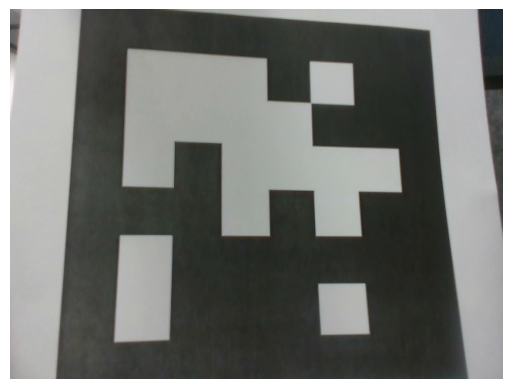

In [172]:
# Load the image
try:
    img = Image.open('photo.jpg')
    img_array = np.array(img)
    # Split the image into RGB channels
    if img_array.shape[-1] != 3: # Check if the image has 3 channels (RGB)
      print("Error: The image does not appear to be an RGB image.")

    print("The captured image")
    plt.axis("off")
    plt.imshow(img_array)


except FileNotFoundError:
    print("Error: The file photo.jpg was not found. Please make sure to capture an image first.")
except Exception as e:
    print(f"An error occurred: {e}")

### Convert the image into grayscale

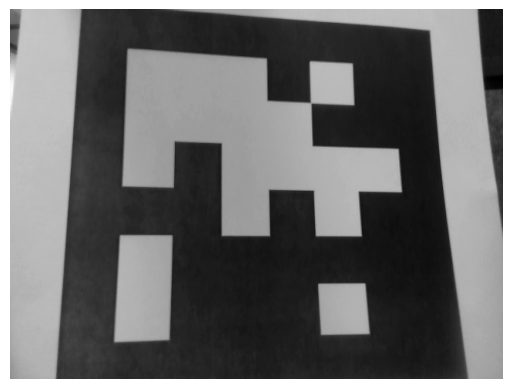

In [73]:
# Convert the image into gray-scale format
img = Image.open('photo.jpg')
# Convert the image to grayscale
img_gray = img.convert('L')

# Convert the grayscale image back to a NumPy array for display
img_gray_array = np.array(img_gray)


plt.axis("off")
plt.imshow(img_gray_array, cmap="gray")
plt.show()

## Part II: Fourier Transform
Reference: 
1. Fourier Transform (FT): https://en.wikipedia.org/wiki/Fourier_transform
2. Discrete Fourier Transform (DFT): https://en.wikipedia.org/wiki/Discrete_Fourier_transform
3. Fast Fourier Transform (FFT) in Numpy: https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html

### Convolution in 1D
The discrete format of convolution in 1D is given as (assume zero-padding for elements out of boundary)
$$
(f * g)_i = \sum_{j=-\infty}^{\infty} f_{i-j} \cdot g_j
$$
In Numpy, we can use $np.convolve()$ to calculate it. 

### Formulas for Fourier Transform
The general formula of Fourier Transform on a continuous complex-valued function f(x) on the real line: 
$$
F(u) = \int_{-\infty}^{\infty} f(x) \exp (-2\pi i \cdot u\cdot x) dx, \forall u\in \mathbb{R}
$$
In application, we often rely on its discrete form. Suppose there a sequence of complex-valued numbers: $\lbrace x_n \rbrace = x_0, x_1, \cdots, x_{N-1}$, the fourier transform will convert the sequence into another sequence $\lbrace X_n \rbrace =X_0, \cdots, X_{N-1}$ where 
$$
X_k = \sum_{n=0}^{N-1} x_n \cdot \exp(-2\pi i \cdot \frac{k}{N} n)
$$

### Fast Fourier Transform from Numpy
In practice, we often use the functions from Numpy to calculate the Discrete Fourier Transfrom (DFT) of a sequence quickly, which is implemented based on the algorithm Fast Fourier Transform (FFT). 

In [2]:
# Define the 1D operations
def convolution_1d(signal, kernel):
    N = len(signal)
    M = len(kernel)
    
    # The length of the output for 'valid' mode
    target_len = N - M + 1
    
    # Reverse the kernel
    kernel_flip = np.flip(kernel)
    
    # Initialize result array with zeros
    result = np.zeros(target_len, dtype=np.double)
    
    # Perform sliding dot product
    for i in range(target_len):
        result[i] = np.dot(signal[i : i + M], kernel_flip)
        
    return result
def create_gaussian_1d(time_space, mean, std):
    x = time_space
    return (np.exp(-(x - mean)**2 / (2 * std**2)))/(np.sqrt(2*np.pi)*std)
def fourier_transform_1d(signal):
    return np.fft.fft(signal)

### Examples

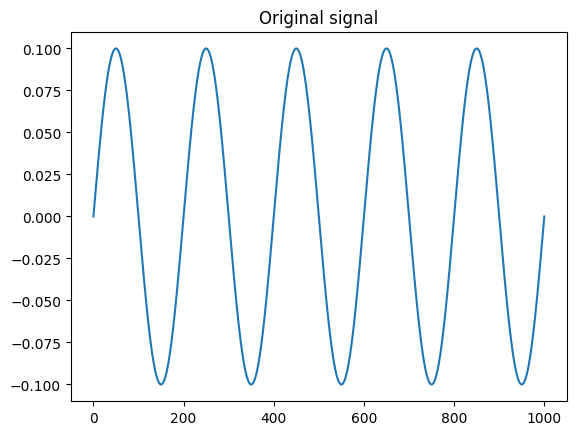

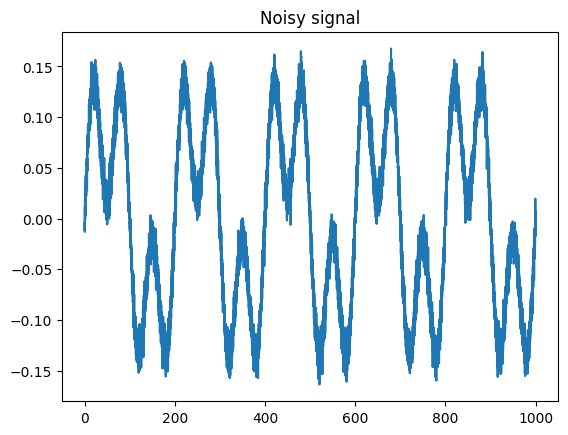

In [36]:
# Create a sample noisy signal
t = np.linspace(0, 1000, 10000)
T = 200
signal = 0.1 * np.sin(2*np.pi/T * t)
signal_noisy = signal + 0.08 * np.sin(6*np.pi/T*t) + 0.01 * np.random.normal(0, 1, len(t))
plt.plot(t, signal)
plt.title("Original signal")
plt.show()
plt.plot(t, signal_noisy)
plt.title("Noisy signal")
plt.show()

### Create a Gaussian-distributed signal

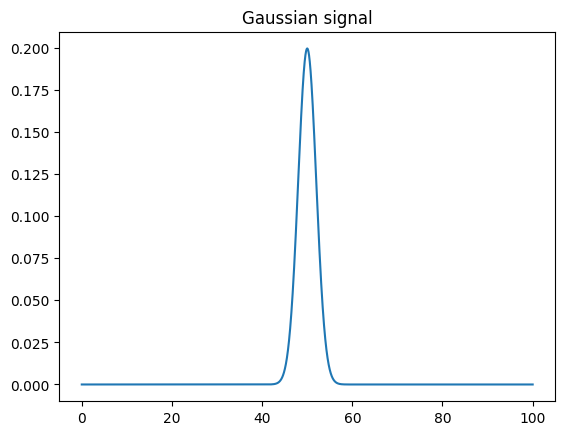

In [37]:
t_gaussian = np.linspace(0, 100, 10000)
mean = 50
std = 2
gaussian_1d = create_gaussian_1d(t_gaussian, mean, std)
plt.plot(np.linspace(0, 100, 10000), gaussian_1d)
plt.title("Gaussian signal")
plt.show()

### Check the DFT of noisy signal & Gaussian signal


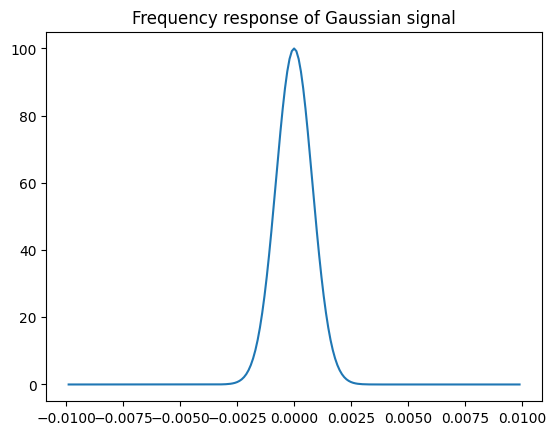

In [38]:
gaussian_1d_ft = np.abs(np.fft.fft(gaussian_1d))
freq = np.fft.fftfreq(t_gaussian.shape[-1])
mask = (freq > -0.01).astype(bool) & (freq < 0.01).astype(bool)

# Extract one window to display
freq_display = freq[mask]
gaussian_1d_ft_display = gaussian_1d_ft[mask]


sort_idx = np.argsort(freq_display)
freq_display = freq_display[sort_idx]
gaussian_1d_ft_display = gaussian_1d_ft_display[sort_idx]
plt.plot(freq_display, gaussian_1d_ft_display)
plt.title("Frequency response of Gaussian signal")
plt.show()

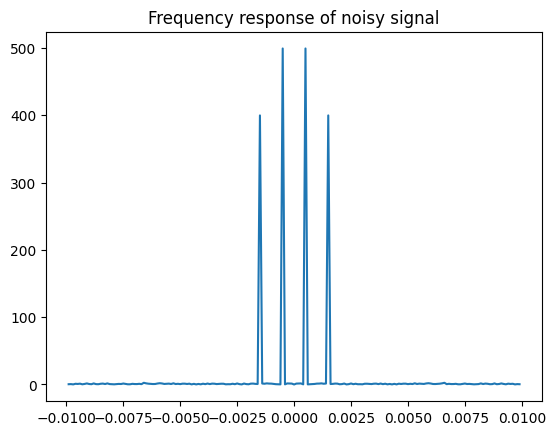

In [39]:
signal_noisy_ft = np.abs(np.fft.fft(signal_noisy))
freq = np.fft.fftfreq(t.shape[-1])
mask = (freq > -0.01).astype(bool) & (freq < 0.01).astype(bool)

# Extract one window to display
freq_display = freq[mask]
signal_noisy_ft_display = signal_noisy_ft[mask]


sort_idx = np.argsort(freq_display)
freq_display = freq_display[sort_idx]
signal_noisy_ft_display = signal_noisy_ft_display[sort_idx]
plt.plot(freq_display, signal_noisy_ft_display)
plt.title("Frequency response of noisy signal")
plt.show()

### Display them in the same figure

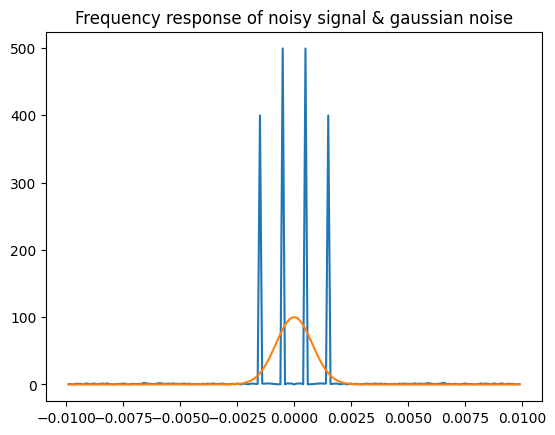

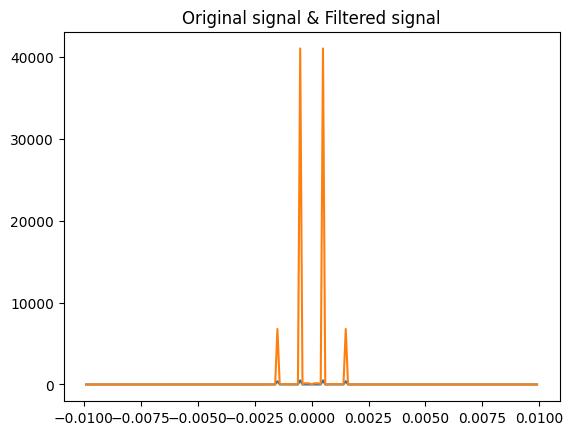

In [40]:
# Demonstrate their frequency responses
plt.plot(freq_display, signal_noisy_ft_display, freq_display, gaussian_1d_ft_display)
plt.title("Frequency response of noisy signal & gaussian noise")
plt.show()

# Calculate their product
signal_filtered = gaussian_1d_ft * signal_noisy_ft
signal_filtered_display = signal_filtered[mask][sort_idx]
plt.plot(freq_display, signal_noisy_ft_display, freq_display, signal_filtered_display)
plt.title("Original signal & Filtered signal")
plt.show()

### Verify that Gaussian signal is a low-pass filter

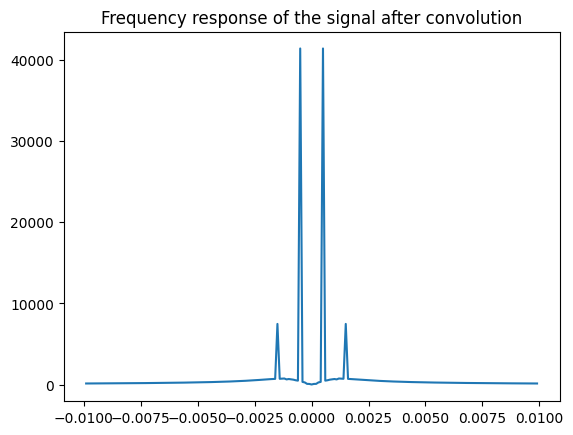

In [41]:
# Calculate convolution between the two signals
signal_noisy_padding = np.pad(signal_noisy, pad_width=(int(len(gaussian_1d)/2), int(len(gaussian_1d)/2) - 1), mode='constant', constant_values=0)
signal_conv = convolution_1d(signal_noisy_padding, gaussian_1d)
signal_conv_ft = np.abs(np.fft.fft(signal_conv))
freq = np.fft.fftfreq(t.shape[-1])
mask = (freq > -0.01).astype(bool) & (freq < 0.01).astype(bool)

# Extract one window to display
freq_display = freq[mask]
signal_conv_ft_display = signal_conv_ft[mask]


sort_idx = np.argsort(freq_display)
freq_display = freq_display[sort_idx]
signal_conv_ft_display = signal_conv_ft_display[sort_idx]
plt.plot(freq_display, signal_conv_ft_display)
plt.title("Frequency response of the signal after convolution")
plt.show()



### Thus, we can reconstruct the original signal by applying Gaussian blurring

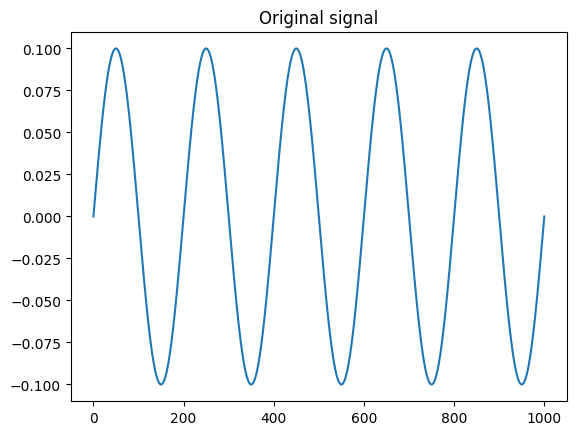

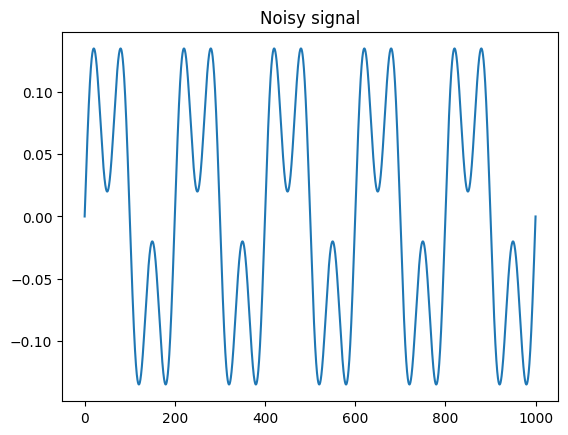

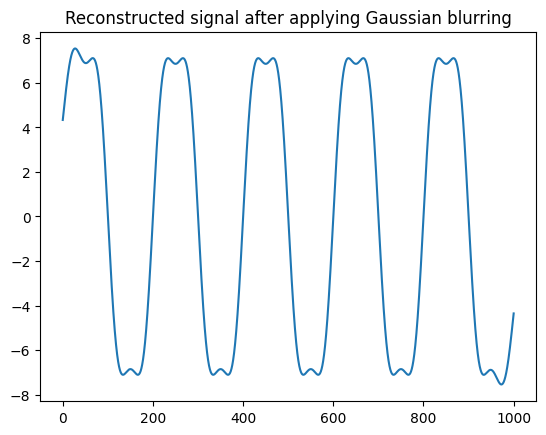

In [23]:
# Reconstruct the signal via inverse FT
plt.plot(t, signal)
plt.title("Original signal")
plt.show()
plt.plot(t, signal_noisy)
plt.title("Noisy signal")
plt.show()
plt.plot(t, signal_conv)
plt.title("Reconstructed signal after applying Gaussian blurring")
plt.show()

### Normalize the signals 

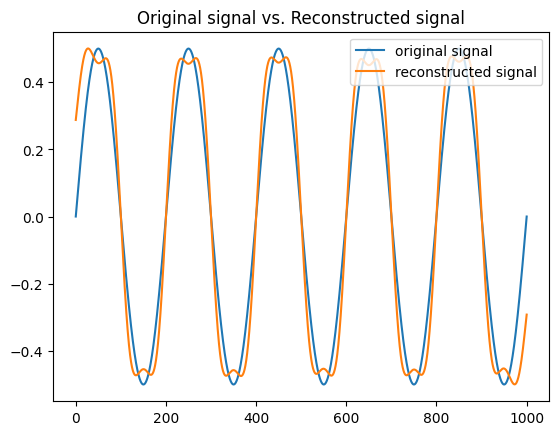

In [171]:
amplitude1 = np.max(signal) - np.min(signal)
plt.title("Original signal vs. Reconstructed signal")
amplitude2 = np.max(signal_conv) - np.min(signal_conv)
plt.plot(t, signal / amplitude1, label = "original signal")
plt.plot(t, signal_conv / amplitude2, label = "reconstructed signal")
plt.legend(loc='upper right')
plt.show()

We can further improve the reconstruction quality by applying another Gaussian blurring

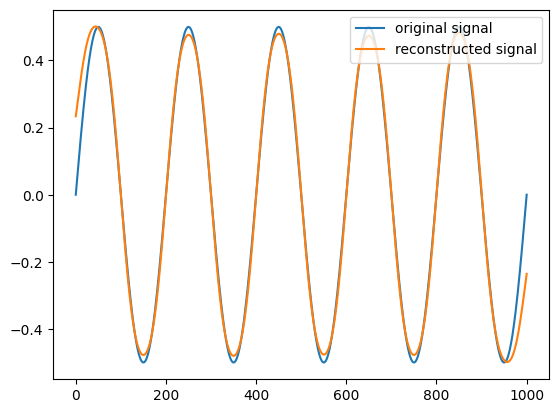

In [172]:
signal_conv_further = np.pad(signal_conv, pad_width=(int(len(gaussian_1d)/2), int(len(gaussian_1d)/2) - 1), mode='constant', constant_values=0)
signal_conv_further = convolution_1d(signal_conv_further, gaussian_1d)
amplitude_further = np.max(signal_conv_further) - np.min(signal_conv_further)
plt.plot(t, signal / amplitude1, label = "original signal")
plt.plot(t, signal_conv_further / amplitude_further, label = "reconstructed signal")
plt.legend(loc='upper right')
plt.show()

## Part 3: Gaussian Filtering Application

### Effects of gaussian filters at different standard deviations

In [59]:
mean1 = 50
std1 = 1
gaussian_1d_1 = create_gaussian_1d(t_gaussian, mean1, std1)
gaussian_1d_1_fft = np.abs(np.fft.fft(gaussian_1d_1))
mean2 = 50
std2 = 2
gaussian_1d_2 = create_gaussian_1d(t_gaussian, mean2, std2)
gaussian_1d_2_fft = np.abs(np.fft.fft(gaussian_1d_2))
mean3 = 50
std3 = 8
gaussian_1d_3 = create_gaussian_1d(t_gaussian, mean3, std3)
gaussian_1d_3_fft = np.abs(np.fft.fft(gaussian_1d_3))
mean4 = 50
std4 = 0.5
gaussian_1d_4 = create_gaussian_1d(t_gaussian, mean4, std4)
gaussian_1d_4_fft = np.abs(np.fft.fft(gaussian_1d_4))

### Check the frequency response

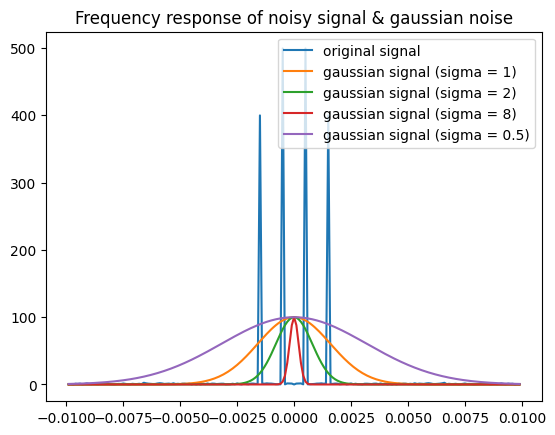

In [60]:
# Demonstrate their frequency responses
gaussian_1d_1_fft_display = gaussian_1d_1_fft[mask][sort_idx]
gaussian_1d_2_fft_display = gaussian_1d_2_fft[mask][sort_idx]
gaussian_1d_3_fft_display = gaussian_1d_3_fft[mask][sort_idx]
gaussian_1d_4_fft_display = gaussian_1d_4_fft[mask][sort_idx]
plt.plot(freq_display, signal_noisy_ft_display, label = "original signal")
plt.plot(freq_display, gaussian_1d_1_fft_display, label = "gaussian signal (sigma = 1)")
plt.plot(freq_display, gaussian_1d_2_fft_display, label = "gaussian signal (sigma = 2)")
plt.plot(freq_display, gaussian_1d_3_fft_display, label = "gaussian signal (sigma = 8)")
plt.plot(freq_display, gaussian_1d_4_fft_display, label = "gaussian signal (sigma = 0.5)")
plt.title("Frequency response of noisy signal & gaussian noise")
plt.legend(loc="upper right")
plt.show()


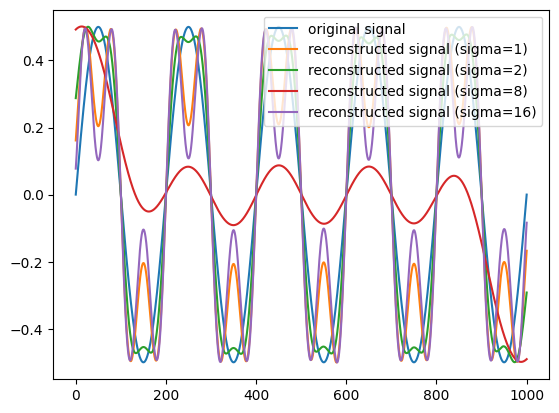

In [61]:
signal_conv1 = convolution_1d(signal_noisy_padding, gaussian_1d_1)
signal_conv2 = convolution_1d(signal_noisy_padding, gaussian_1d_2)
signal_conv3 = convolution_1d(signal_noisy_padding, gaussian_1d_3)
signal_conv4 = convolution_1d(signal_noisy_padding, gaussian_1d_4)
amplitude = np.max(signal) - np.min(signal)

amplitude1 = np.max(signal_conv1) - np.min(signal_conv1)
amplitude2 = np.max(signal_conv2) - np.min(signal_conv2)
amplitude3 = np.max(signal_conv3) - np.min(signal_conv3)
amplitude4 = np.max(signal_conv4) - np.min(signal_conv4)
plt.plot(t, signal / amplitude, label = "original signal")
plt.plot(t, signal_conv1 / amplitude1, label = "reconstructed signal (sigma=1)")
plt.plot(t, signal_conv2 / amplitude2, label = "reconstructed signal (sigma=2)")
plt.plot(t, signal_conv3 / amplitude3, label = "reconstructed signal (sigma=8)")
plt.plot(t, signal_conv4 / amplitude4, label = "reconstructed signal (sigma=16)")
plt.legend(loc='upper right')
plt.show()

### Band-pass filter

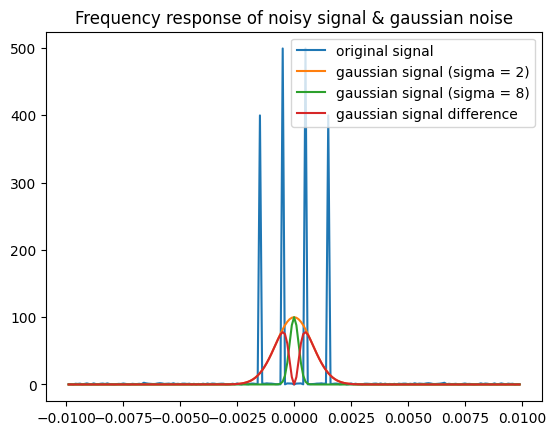

In [64]:
gaussian_diff = gaussian_1d_2 - gaussian_1d_3
gaussian_diff_fft = np.abs(np.fft.fft(gaussian_diff))
gaussian_diff_fft_display = gaussian_diff_fft[mask][sort_idx]

plt.plot(freq_display, signal_noisy_ft_display, label = "original signal")
plt.plot(freq_display, gaussian_1d_2_fft_display, label = "gaussian signal (sigma = 2)")
plt.plot(freq_display, gaussian_1d_3_fft_display, label = "gaussian signal (sigma = 8)")
plt.plot(freq_display, gaussian_diff_fft_display, label = "gaussian signal difference")
plt.title("Frequency response of noisy signal & gaussian noise")
plt.legend(loc="upper right")
plt.show()

### Laplacian (Check the shape)

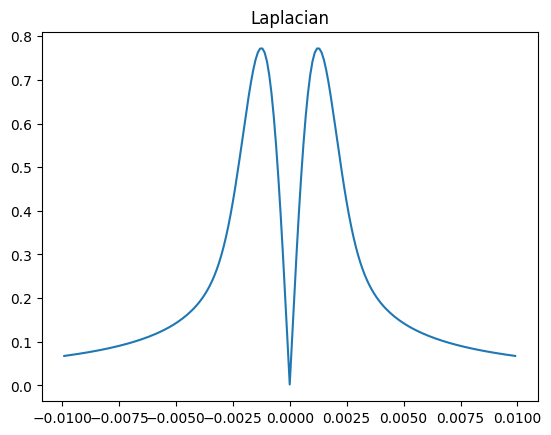

In [119]:
x = t_gaussian
sigma = 2
gaussian_laplace =  (x**2 / sigma**4 - 1 / sigma**2) * np.exp(-x**2 / (2 * sigma**2))

# Normalize the second derivative kernel (optional, but good for consistency)
gaussian_laplace/= np.sum(np.abs(gaussian_laplace))
gaussian_laplace_fft = np.abs(np.fft.fft(gaussian_laplace))
gaussian_laplace_fft_display = gaussian_laplace_fft[mask][sort_idx]
plt.plot(freq_display, gaussian_laplace_fft_display)
plt.title("Laplacian")
plt.show()

### Gaussian blurring & Sub-samplling

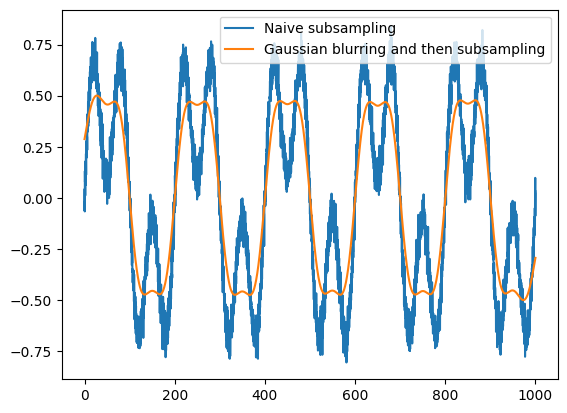

In [173]:
# Naive sub-sampling
signal_subsample = signal_noisy[::2]
plt.plot(t[::2], signal_subsample / amplitude, label="Naive subsampling")
signal_gaussian_subsample = signal_conv2[::2]
plt.plot(t[::2], signal_gaussian_subsample / amplitude2, label = "Gaussian blurring and then subsampling")
plt.legend(loc="upper right")
plt.show()

### Signal Reconstruction via Naive subsampling & upsampling

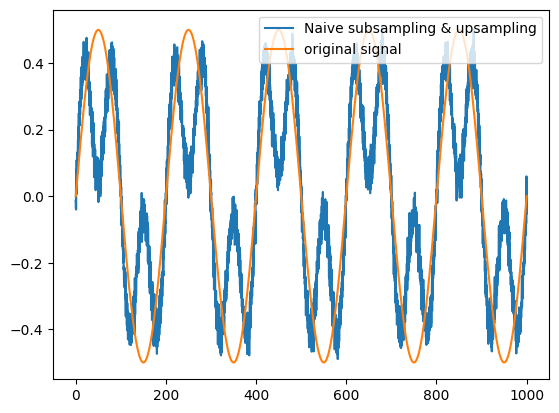

In [180]:
signal_subsample = signal_noisy[::2]
signal_gaussian_subsample = signal_conv2[::2]
signal_laplacian = signal_noisy - signal_conv2

# Naive upsampling
signal_upsample = np.zeros(2 * len(signal_subsample))
signal_upsample[::2] = signal_subsample
signal_upsample[1::2] = signal_subsample


amplitude_upsample = np.max(signal_gaussian_upsample) - np.min(signal_gaussian_upsample)
plt.plot(t, signal_upsample / (np.max(signal_upsample) - np.min(signal_upsample)), label="Naive subsampling & upsampling")
plt.plot(t, signal / amplitude, label="original signal")
plt.legend(loc="upper right")
plt.show()

### Signal Reconstruction via Laplacian & Gaussian blurring

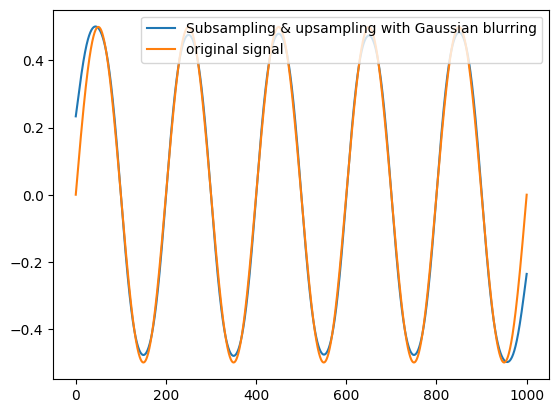

In [188]:
signal_gaussian_subsample = signal_conv2[::2]


# Upsampling via Gaussian blurring & Laplacian
signal_gaussian_upsample = np.zeros(2 * len(signal_gaussian_subsample))
signal_gaussian_upsample[::2] = signal_gaussian_subsample
signal_gaussian_upsample[1::2] = signal_gaussian_subsample

# Apply another Gaussian blurring to further remove high-frequency elements
signal_gaussian_upsample = np.pad(signal_gaussian_upsample, pad_width=(int(len(gaussian_1d)/2), int(len(gaussian_1d)/2) - 1), mode='constant', constant_values=0)
signal_gaussian_upsample = convolution_1d(signal_gaussian_upsample, gaussian_1d_2)


amplitude_upsample = np.max(signal_gaussian_upsample) - np.min(signal_gaussian_upsample)
plt.plot(t, signal_gaussian_upsample / amplitude_upsample, label = "Subsampling & upsampling with Gaussian blurring")
plt.plot(t, signal / amplitude, label="original signal")
plt.legend(loc="upper right")
plt.show()

We can see that with gaussian blurring on the target signal at first, we can filter out the high-frequency noise and reconstruct the original signal in a better way

### Summary
1. Gaussian blurring can act as a low-pass filter to help in removing high-frequency noise
2. Due to its ability to remove the high-frequency noise, Gaussian blurring can help to improve the quality of signal reconstruction via subsampling & upsampling

## Part 4: Image Pyramid

We can extend these ideas into 2D images reconstruction

### Gaussian kernels, Convoultion, sub/up-sampling in 2D

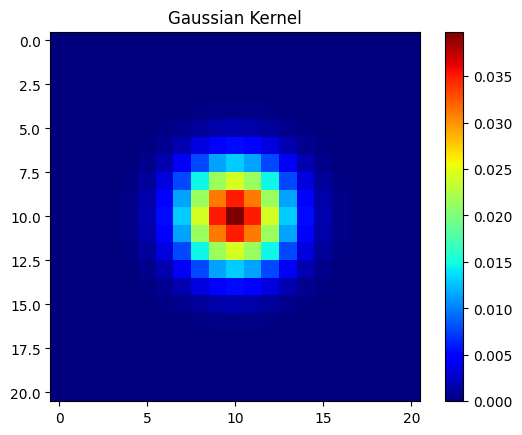

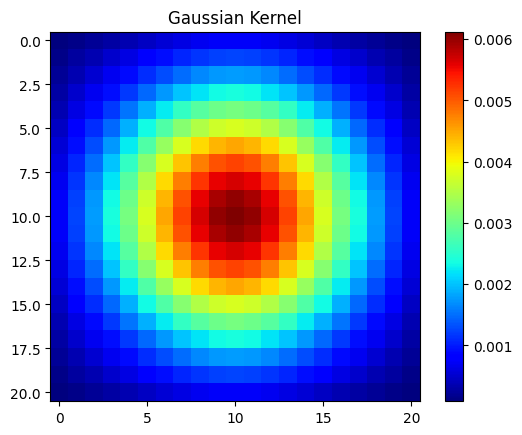

In [126]:
# Image convolution
def image_correlation(image_array, kernel):
    # Assume a gray-scale image
    assert len(image_array.shape) == 2, "Assume a grayscale image so far"
    H, W = image_array.shape
    kh, kw = kernel.shape
    
    # Correlation
    image_array_processed= np.zeros((H - kh + 1, W - kw + 1))
    for i in range(H - kh + 1):
        for j in range(W - kw + 1):
            image_array_processed[i, j] = np.sum(image_array[i:i+kh, j:j+kw] * kernel)
    return image_array_processed
def image_convolution(image_array, kernel):
    kernel_flipped = np.flip(kernel)
    return image_correlation(image_array, kernel_flipped)

def create_gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / (2 * np.pi * sigma**2)

kernel_size = 21
sigma = 2
gaussian_kernel = create_gaussian_kernel(kernel_size, sigma)
def visualize_gaussian_kernel(kernel):
    plt.close()
    plt.imshow(kernel, cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.title('Gaussian Kernel')
    plt.show()
visualize_gaussian_kernel(gaussian_kernel)

plt.close()
g1 = create_gaussian_kernel(kernel_size, 1)
g2 = create_gaussian_kernel(kernel_size, 5)
g1_padding = np.pad(g1, pad_width=(int)((kernel_size - 1)/2), mode='constant', constant_values=0)
g3 = image_convolution(g1_padding, g2)
visualize_gaussian_kernel(g3)

### Naive subsampling & upsampling

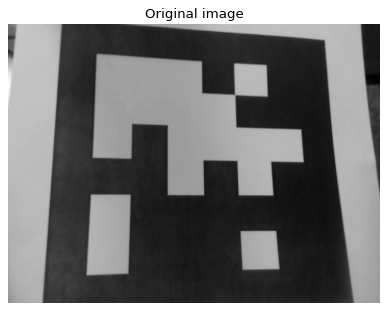

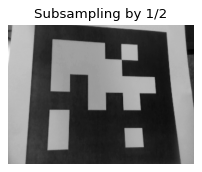

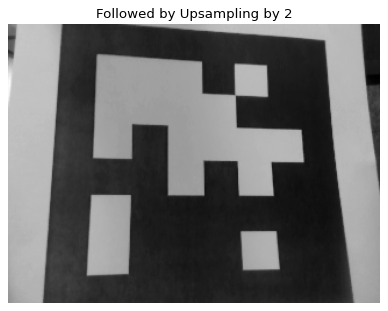

In [101]:
def subsampling(image, ratio=1/2):
    step = int(1/ratio)
    return image[::step, ::step]
def upsampling(image, ratio=2):
    return image.repeat(ratio, axis=0).repeat(ratio, axis=1)
dpi = 80

plt.figure(figsize=(int(img_gray_array.shape[0]/dpi), int(img_gray_array.shape[1]/dpi)), dpi=dpi)
plt.axis("off")
plt.imshow(img_gray_array, cmap="gray")
plt.title("Original image")
plt.show()

img_subsample = subsampling(img_gray_array)
plt.figure(figsize=(int(img_subsample.shape[0]/dpi), int(img_subsample.shape[1]/dpi)), dpi=dpi)
plt.axis("off")
plt.imshow(img_subsample, cmap="gray")
plt.title("Subsampling by 1/2")
plt.show()

img_upsample = upsampling(img_subsample)
plt.figure(figsize=(int(img_upsample.shape[0]/dpi), int(img_upsample.shape[1]/dpi)), dpi=dpi)
plt.axis("off")
plt.title("Followed by Upsampling by 2")
plt.imshow(img_upsample, cmap="gray")
plt.show()

### Results from naive subsampling & upsampling (aliasing effects!)

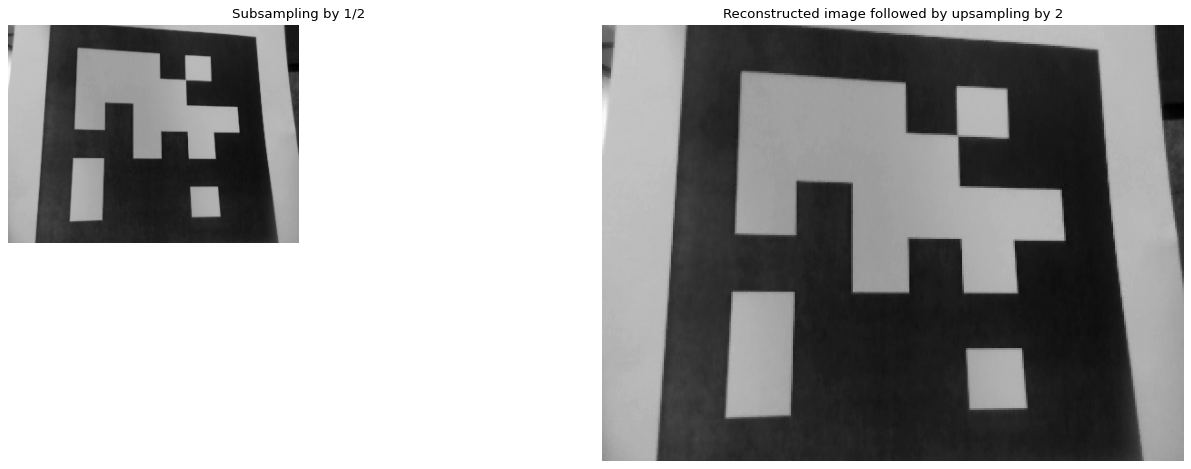

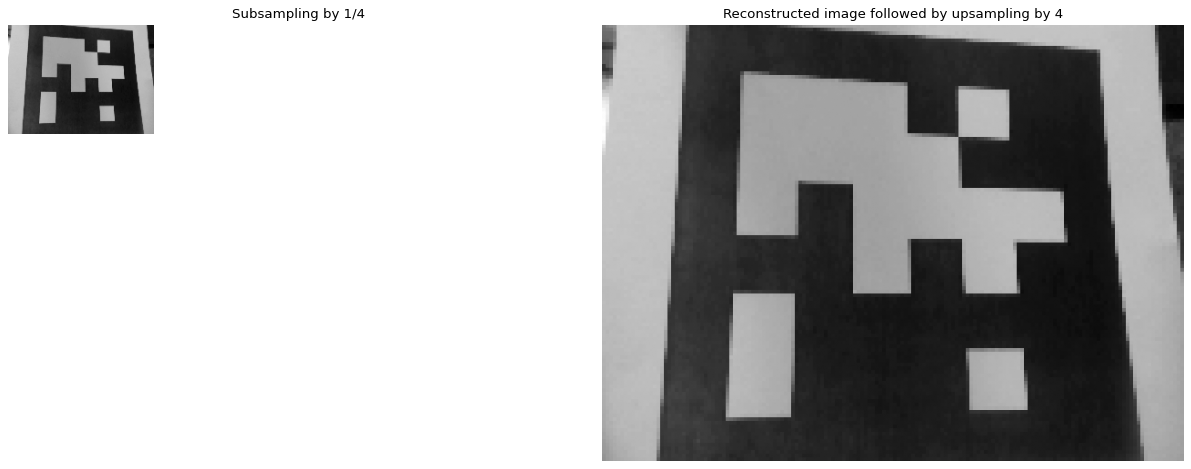

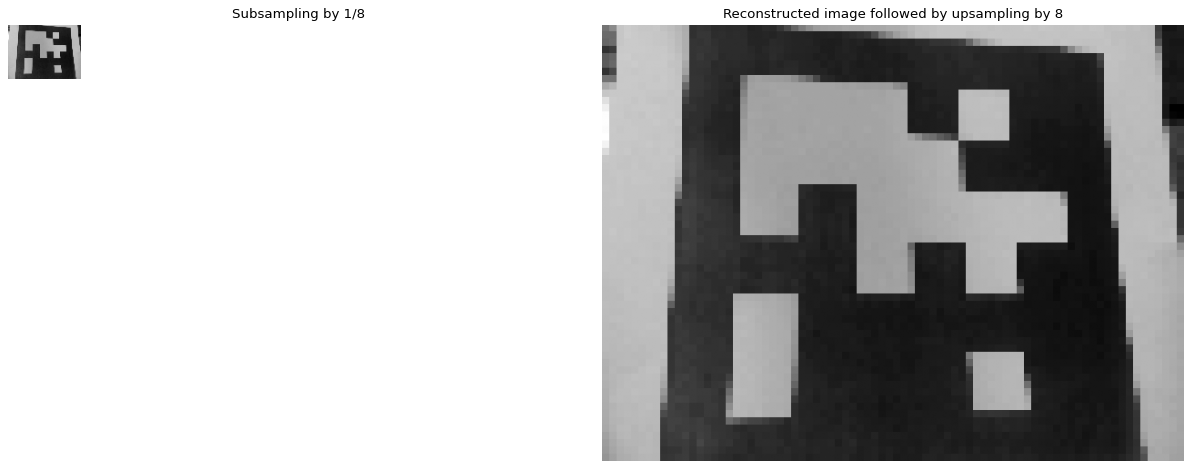

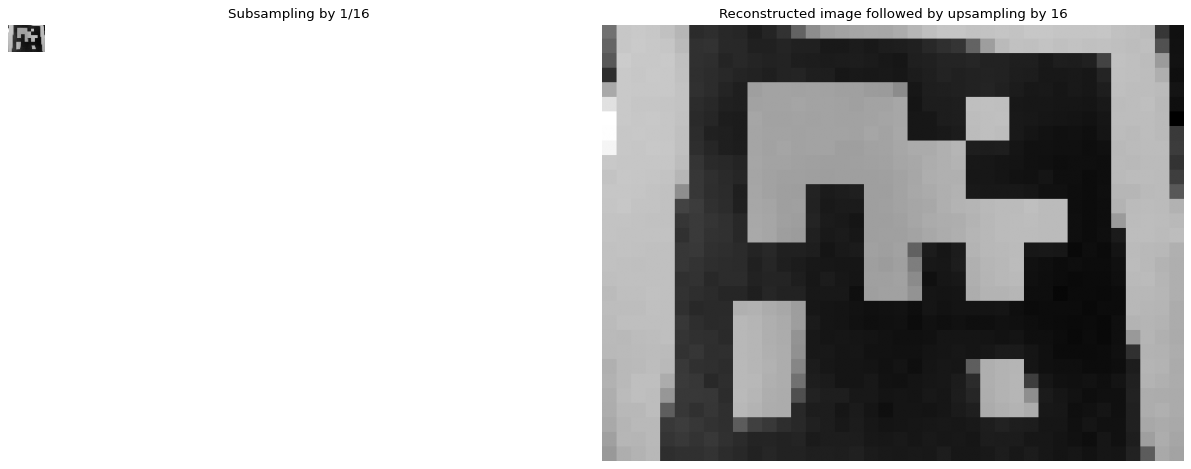

In [163]:
ratios = [2, 4, 8, 16]
for i in ratios:
    img_subsample = subsampling(img_gray_array, ratio = 1/i)
    img_upsample = upsampling(img_subsample, ratio = i)
    # Create a figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), dpi=80, sharex=True, sharey=True)


    # Display the vertical edge detection
    axes[0].imshow(img_subsample, cmap='gray')
    axes[0].set_title('Subsampling by 1/' + str(i))
    axes[0].axis('off')
    
    # Display the horizontal edge detection
    axes[1].imshow(img_upsample, cmap='gray')
    axes[1].set_title('Reconstructed image followed by upsampling by ' + str(i))
    axes[1].axis('off')
    
    
    plt.tight_layout()
    plt.show()

### Subsampling with Gaussian blurring

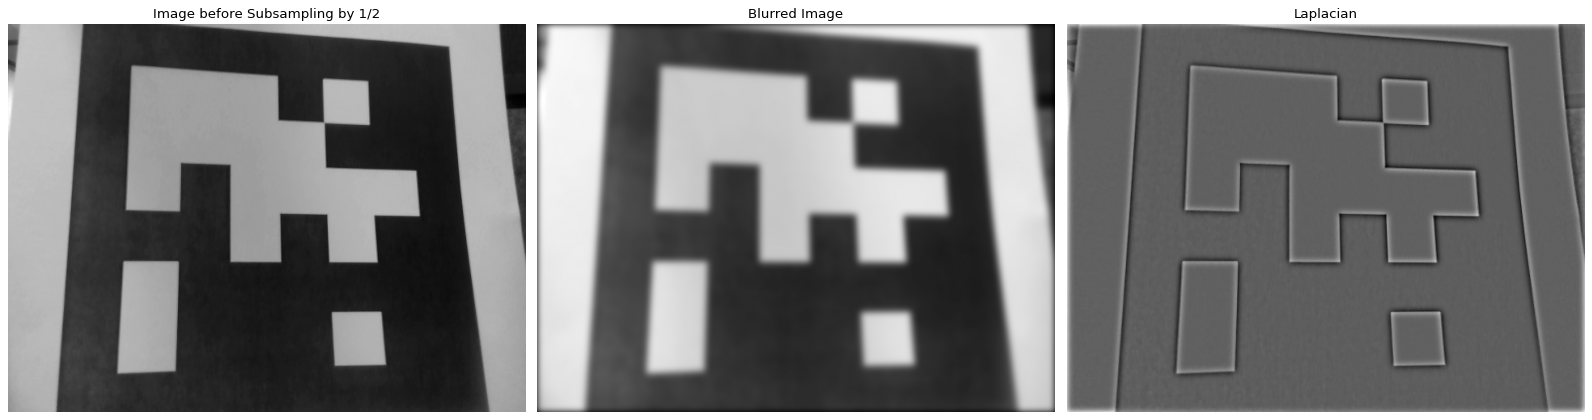

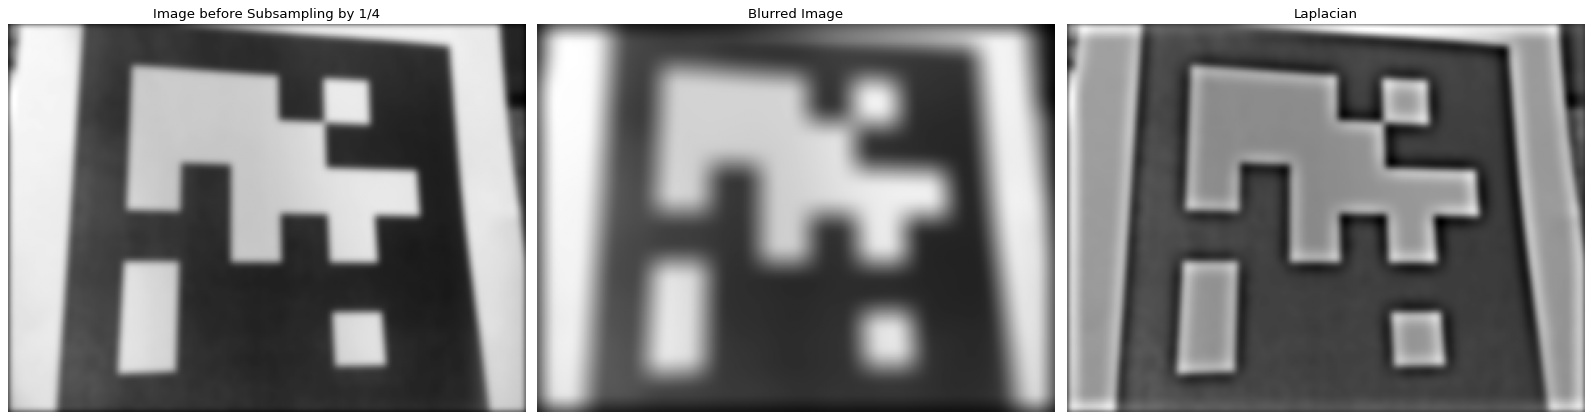

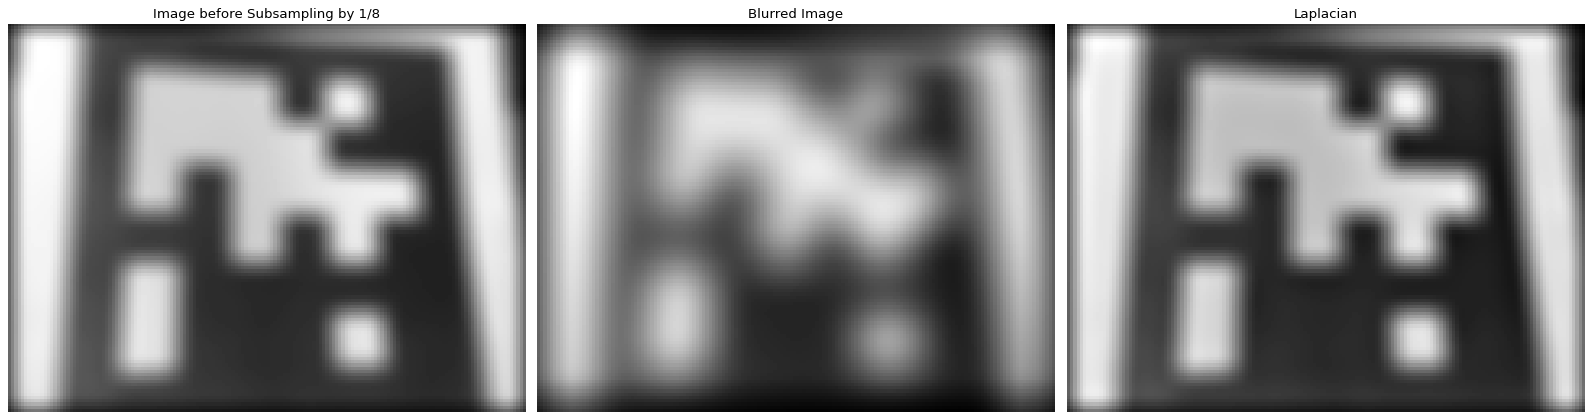

In [164]:
# Display the results
ratios = [2, 4, 8]
image_pyramids = []
image_laplacians = []
# The original image
img_subsample = np.copy(img_gray_array)
for i in ratios:

    # Blur the image & Calculate the laplacian
    kernel = create_gaussian_kernel(21, sigma = 2*i)
    img_subsample_padding = np.pad(img_subsample, pad_width=(int)((kernel_size - 1)/2), mode='constant', constant_values=0)
    img_blur = image_convolution(img_subsample_padding, kernel)
    img_laplacian = img_subsample - img_blur
    img_display = np.copy(img_subsample)
    
    image_laplacians.append(img_laplacian)
    # Create a figure
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), dpi=80, sharex=True, sharey=True)

    # Display the subsampled image from last step
    axes[0].imshow(img_display, cmap='gray')
    axes[0].set_title('Image before Subsampling by 1/' + str(i))
    axes[0].axis('off')
    
    # Display the blurred image
    axes[1].imshow(img_blur, cmap='gray')
    axes[1].set_title('Blurred Image')
    axes[1].axis('off')
    
    # Display the horizontal edge detection
    axes[2].imshow(img_laplacian, cmap='gray')
    axes[2].set_title('Laplacian')
    axes[2].axis('off')
    
    
    plt.tight_layout()
    plt.show()
    plt.close()
    # Subsample the image
    img_subsample = subsampling(img_blur, ratio = 1/2)
    image_pyramids.append(img_subsample)
    

### Image Reconstruction via Upsampling

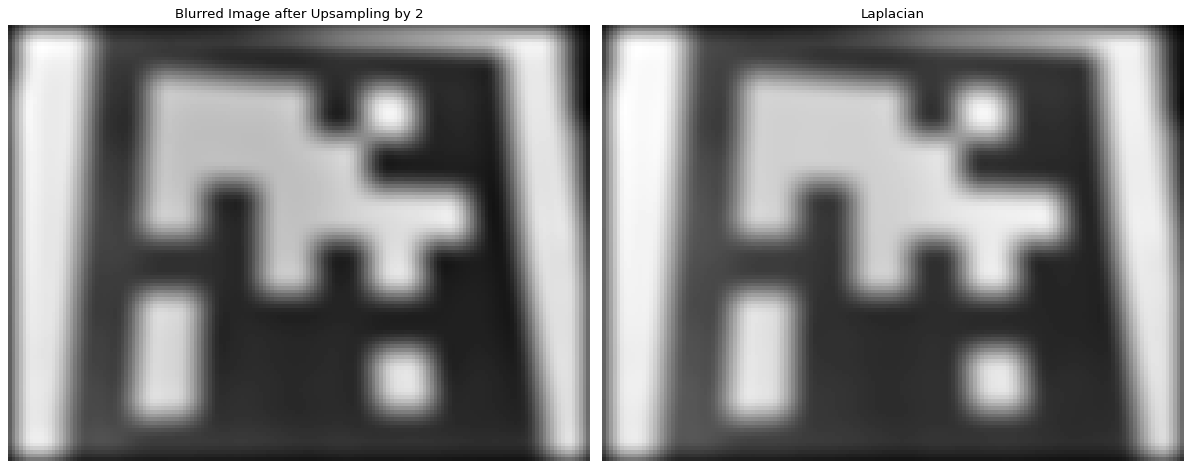

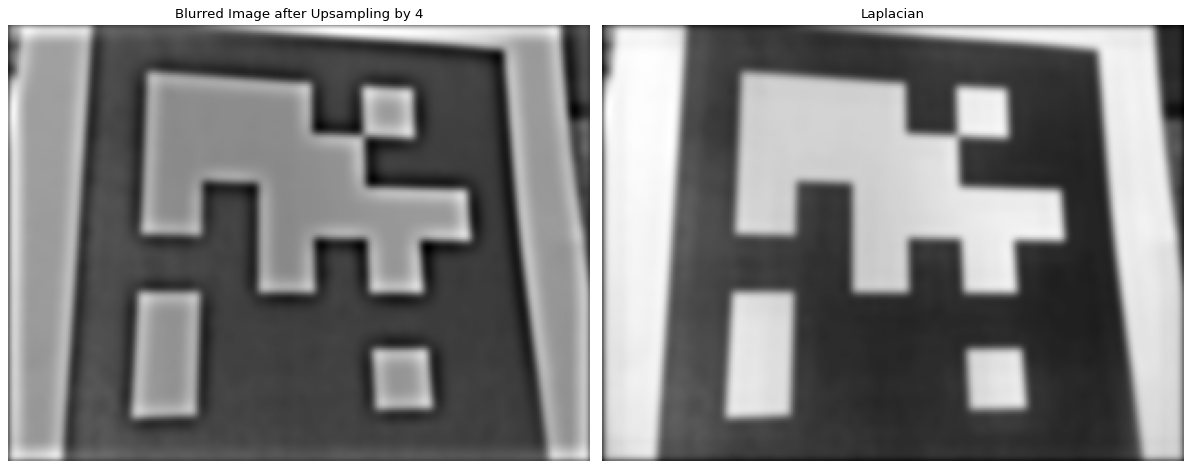

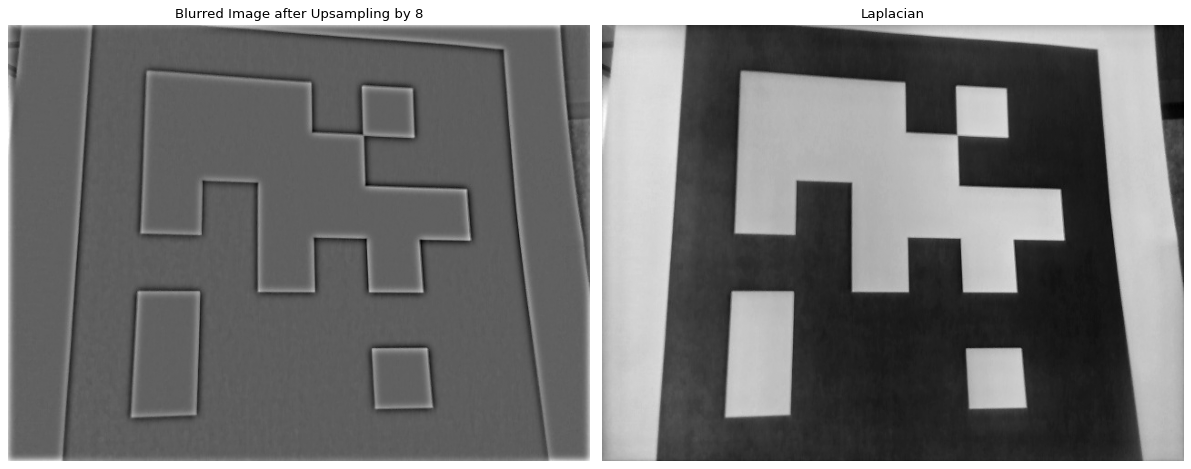

In [165]:
img_upsample = image_pyramids[-1]

for i in range(len(ratios)):
    kernel = create_gaussian_kernel(21, sigma = 2 * ratios[len(ratios)-1-i]/2)

    # Upsampling & blur
    img_upsample = upsampling(img_upsample, ratio=2)
    img_upsample_padding = np.pad(img_upsample, pad_width=(int)((kernel_size - 1)/2), mode='constant', constant_values=0)
    img_upsample = image_convolution(img_upsample_padding, kernel)

    # Add the image laplacian back
    img_laplacian = image_laplacians[len(ratios)-1-i]
    img_reconstructed = img_upsample + img_laplacian

    img_display = np.copy(img_reconstructed)
    # Create a figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), dpi=80, sharex=True, sharey=True)


    # Display the vertical edge detection
    axes[0].imshow(img_laplacian, cmap='gray')
    axes[0].set_title('Blurred Image after Upsampling by ' + str(ratios[i]))
    axes[0].axis('off')
    
    # Display the horizontal edge detection
    axes[1].imshow(img_display, cmap='gray')
    axes[1].set_title('Laplacian')
    axes[1].axis('off')
    
    
    plt.tight_layout()
    plt.show()
    plt.close()

    img_upsample = img_reconstructed
    